In [1]:
a = [7,7,9,7,10,9,9]
a += [9,7,10,7,7,7,8,9,8]
a += [6,8,8,9,7,8,10]
a += [9,9,9,8,10,7,8,10,10,8]
np.mean(a)

NameError: name 'np' is not defined

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
%pylab inline
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from numpy.linalg import norm
from numpy import copy

from scipy.stats import probplot
import scipy as sp

from ipywidgets import FloatProgress
from IPython.display import display

import timeit

import fibonacci_heap_mod as fhm

from scipy.sparse import csr_matrix
from scipy import sparse

Populating the interactive namespace from numpy and matplotlib


## Постановка задачи

$$\begin{array}{lcl} f(x) = \frac{1}{2} \left\lVert Ax-y\right\rVert^{2} + \frac{\mu}{2} \left\lVert x\right\rVert^{2} \\
\nabla f(x) = \mu x + A^T  (Ax - y) \end{array}$$

Где $A$ -- плотная $m\cdot n$ матрица <br>
$y$ -- $m\cdot 1$ вектор ответов <br>
$x$ -- $n\cdot 1$ искомый вектор

Пусть:

$H = \widetilde{A}^T\widetilde{A} + \mu \widetilde{I}$

Где:

$\widetilde{A} = \begin{bmatrix} y & -X \end{bmatrix}$
$\widetilde{I} = \begin{bmatrix} 0 & 0 \\ 0 & I_n \end{bmatrix}$

Дополним пространство $D$ допустимых ответов как $\widetilde{D} = \{1\}\times D$, и перепишем исходную задачу как:

$\widetilde{f}(\beta) = \left(\widetilde{A}\beta\right)^T\left(\widetilde{A}\beta\right)^T + \beta^T\widetilde{I}\beta \to \min_\limits{\beta \in \widetilde{D}}$

Дифференцируя по $\beta$ получаем:

$\nabla \widetilde{f}(\beta) = H\beta$

Вводя $z_k = \frac{x_k}{b_k}$ сохраняя обозначения из статьи получаем, что:

$\arg \min H\beta_k \sim \arg\min H \begin{bmatrix}b_{k+1}^{-1} \\ z_k\end{bmatrix}$

## Спарсификация исходных данных

In [4]:
from lib.sparsification import arora_sparsification, bernstein_sparsification, metropolis_sparsification

## Алгоритм на csr-матрицах

In [8]:
%%time

n = int(1e2)
m = n
mu = 1/n
X = sparse.rand(m, n, density=1).tocsr()
x_true = sparse.rand(1, n, density=1).tocsr()
#X = arora_sparsification(array(X), 15*e_lower_lim)
x_true /= x_true.sum()
y = X.dot(x_true.T)
e_lower_lim = X.max()
print("%.6f%% of non-zero elements"%(100*len(X.nonzero()[1])/(n*m)))
print("%d non-zero elements"%(len(X.nonzero()[1])))
start_point = sparse.rand(1, n, density=100/n).tocsr()
start_point /= start_point.sum()

100.000000% of non-zero elements
10000 non-zero elements
CPU times: user 5.91 ms, sys: 1.31 ms, total: 7.22 ms
Wall time: 5.95 ms


In [229]:
x1 = sparse.hstack([sparse.eye(1), start_point]).tolil()
for _, i in zip(*x1.nonzero()):
    print(i, x1[0, i])

0 1.0
3 0.0176951425935
5 0.0186162146544
7 0.00403482712507
18 0.000388666098522
25 0.00395741074661
33 0.00622869782882
34 0.00145620946066
57 0.0190479831627
62 0.000322379620868
108 0.00466889789106
127 0.0086783748065
138 0.0136555182852
146 0.00545403204791
148 0.00543918736193
156 0.0114881313685
184 0.011887185474
191 0.00390974355024
198 0.0028188114474
201 0.00847329081171
209 0.0180349885571
212 0.00432465715176
217 0.0177407889589
223 0.0120587364629
234 0.008289712646
246 0.00181257525612
247 0.0123598164845
262 0.014597787124
268 0.0135922042588
276 0.015995367494
280 0.0135181383142
281 0.00953858805987
312 0.018686331038
336 0.0134577581801
358 0.00691127353568
365 0.0129163912549
373 0.00535561115987
383 0.00704059861504
384 0.0181035833055
388 0.0159012207671
404 0.0190198448092
422 0.012321659567
434 0.0113321824559
439 0.00177487668276
442 0.00441392430732
455 0.0144687504535
458 0.019577394489
487 0.0193445733504
495 0.00401530825857
497 0.0188045414631
504 0.00191

In [129]:
n = 100
m = 100
mu = 1/n
X = rand(m, n)
x_true = rand(n)
x_true /= sum(x_true)
y = dot(X, x_true)
e_lower_lim = X.max()
X = arora_sparsification(array(X), 15*e_lower_lim)
print("%.1f%% of non-zero elements"%(100*sum(X != 0)/(n*m)))

start_point = rand(n)
start_point /= sum(start_point)

3.2% of non-zero elements


In [11]:
from lib.optimization import CCD_sparse

In [9]:
%%time

alg = Ridge(alpha=1/n, tol=1e-7)
alg.fit(X, np.squeeze(y.toarray()))
x_sklearn = alg.coef_
error = norm(alg.predict(X) - y)
error

CPU times: user 140 ms, sys: 2.66 ms, total: 142 ms
Wall time: 143 ms


/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [21]:
%%time
x, message, history = CCD_sparse(X, y, mu, start_point, e = 1e-3, k_max = 300)

ValueError: dimension mismatch

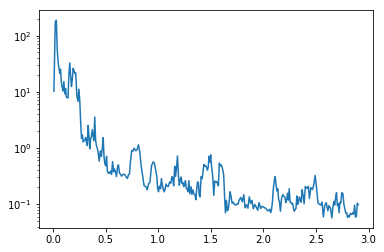

In [13]:
semilogy(history["time"], history["g_norm"])
scatter()

In [442]:
print("%12s %12s"%("SkLearn", "CCD"))
print(array([np.squeeze(x_true.toarray()), np.squeeze(x_ccd_a.toarray())]).T[:10])
print("CCD with armiho: %d iterations"%(steps_ccd_a))
#print("CCD wi/o armiho: %d iterations"%(steps_ccd))
print("%23s"%"Accuracy")
print("%14.4f %14.4f %14.4f"%(norm(alg.predict(X) - y), 
                        norm(np.squeeze((X.dot(x_ccd_a.T) - y).toarray())),
                        norm(X.dot(x_ccd_a.T) - alg.predict(X))))

     SkLearn          CCD
[[  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.95093096e-05]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]]
CCD with armiho: 133 iterations
               Accuracy
       31.4798         2.2056        69.4898


In [422]:
sum(x_ccd_a != 0)

119

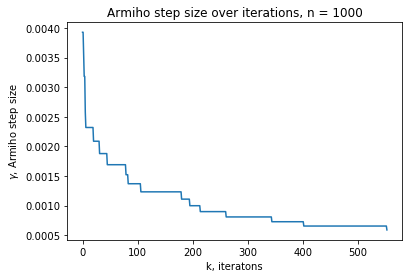

In [1604]:
plot(gammas)
xlabel("k, iteratons")
ylabel("$\gamma$, Armiho step size")
title("Armiho step size over iterations, n = 1000")

In [1610]:
import pandas as pd
gammas_series = pd.Series(gammas)
gammas_series.to_csv("armiho_steps.csv")

## Эксперименты с ассимптотикой по размерности пространства

In [1543]:
%%time

iters_n = []
sparsity_n = []
time_n = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 12
display(progress_bar)

for i in [5, 10, 25, 50, 75, 100, 200, 300]:
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = i
        m = 3*n
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        X = sparsify(array(X), e_lower_lim+0.01)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_n.append(mean(local_iters))
    sparsity_n.append(mean(local_sparsity))
    time_n.append(mean(local_time))
    progress_bar.value += 1

/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


CPU times: user 10min 43s, sys: 10.6 s, total: 10min 54s
Wall time: 15min 24s


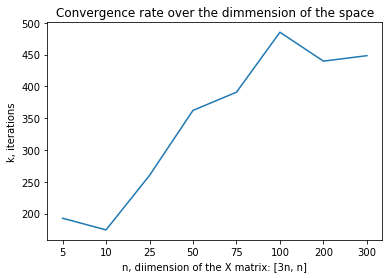

In [1544]:
plot(iters_n)
xticks(range(len(iters_n)), [5, 10, 25, 50, 75, 100, 200, 300])
xlabel("n, diimension of the X matrix: [3n, n]")
ylabel("k, iterations")
title("Convergence rate over the dimmension of the space")

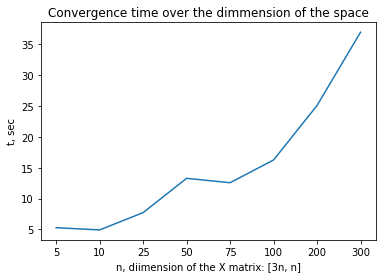

In [1545]:
plot(time_n)
xticks(range(len(iters_n)), [5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("n, diimension of the X matrix: [3n, n]")
ylabel("t, sec")
title("Convergence time over the dimmension of the space")

## Эксперименты на степень разреженности

In [1213]:
%%time

iters_s = []
sparsity_s = []
time_s = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 20
display(progress_bar)

for i in range(1, 21):
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = 200
        m = 3*n
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        X = sparsify(array(X), e_lower_lim*i)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_s.append(mean(local_iters))
    sparsity_s.append(mean(local_sparsity))
    time_s.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 46min 50s, sys: 50.8 s, total: 47min 41s
Wall time: 1h 39min 42s


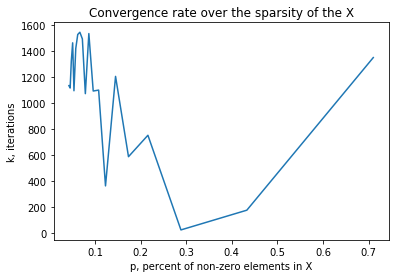

In [1253]:
plot(sparsity_s, iters_s)
xlabel("p, percent of non-zero elements in X")
ylabel("k, iterations")
title("Convergence rate over sparsity of the X")

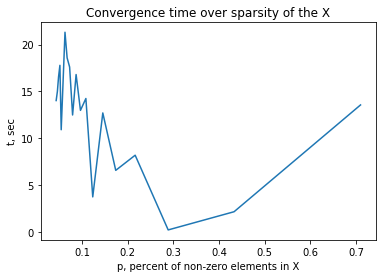

In [1254]:
plot(sparsity_s, time_s)
xlabel("p, percent of non-zero elements in X")
ylabel("t, sec")
title("Convergence time over sparsity of the X")

## Эксперимент про ассимптотики по числу строк матрицы X

In [1291]:
%%time

iters_m = []
sparsity_m = []
time_m = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 11
display(progress_bar)

for i in [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000]:
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = 10
        m = i
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        #e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        #X = sparsify(array(X), e_lower_lim+0.01)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_m.append(mean(local_iters))
    sparsity_m.append(mean(local_sparsity))
    time_m.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 2min 14s, sys: 2.83 s, total: 2min 17s
Wall time: 1min 56s


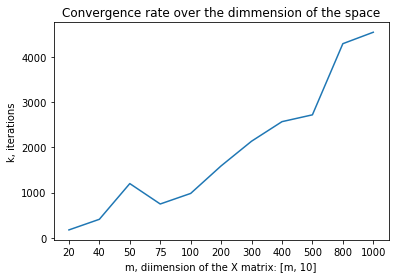

In [1294]:
plot(iters_m)
xticks(range(len(iters_m)), [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("m, diimension of the X matrix: [m, 10]")
ylabel("k, iterations")
title("Convergence rate over the dimmension of the space")

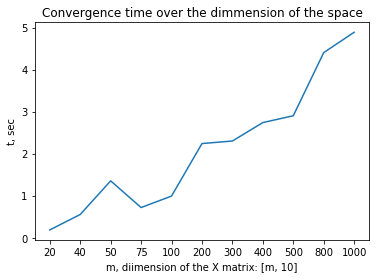

In [1293]:
plot(time_m)
xticks(range(len(iters_m)), [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("m, diimension of the X matrix: [m, 10]")
ylabel("t, sec")
title("Convergence time over the dimmension of the space")

## Эксперимент о зависимости скорости сходимости от начального приближения

In [1295]:
%%time

iters_l = []
sparsity_l = []
time_l = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 20
display(progress_bar)

n = 10
m = 100
mu = 1/n
x_true = rand(n)
x_true /= sum(x_true)
X = rand(m, n)
y = dot(X, x_true)
e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
X = sparsify(array(X), e_lower_lim*10)
angle_point = np.zeros(n)
angle_point[0] = 1

for i in linspace(0, 1, 20):
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        start_point = i*x_true + (1-i)*angle_point
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_l.append(mean(local_iters))
    sparsity_l.append(mean(local_sparsity))
    time_l.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 3min 15s, sys: 3.37 s, total: 3min 18s
Wall time: 3min 24s


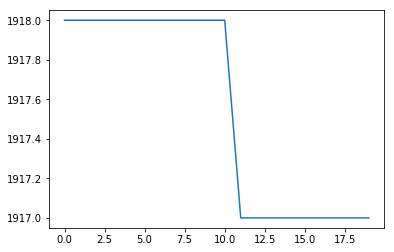

In [1296]:
plot(iters_l)

## Бэкапы

In [12]:
def f_dense(x, X, y, mu):
    return norm(dot(X, x) - y)**2 + mu/2*norm(x)**2

def grad_f_dense(x, X, y, mu):
    return 2*dot(X.T, dot(X, x) - y) + mu*x

Первая заработавшая версия

In [ ]:
def CCD(X, y, mu, x0, M, e, k_max = 1e4):
    n = len(x0)
    
    steps = [x0]
    
    A = c_[y, -X]
    I = np.zeros((n+1, n+1))
    I[1:, 1:] = np.eye(n)
    H = (dot(A.T, A) + mu*I).T
    
    def grad(x):
        return dot(dot(X.T, X), x) - dot(X.T,y) + mu*x
    
    g_x = grad(x0)
    heap = fhm.Fibonacci_heap()
    g_elems = []
    for i, val in enumerate(g_x):
        g_elems.append(heap.enqueue(i, val))
    
    x = x0
    x_prev = 3*x0
    beta = 1
    z = x/beta
    z_prev = 3*z
    
    for i in range(1, int(k_max)):
        min_coord = heap.min().get_value()
        gf = argmin(grad(x))
        d = np.zeros(n)
        d[gf] = 1

        #if norm(x - x_prev) < e*norm(x):      # по относительному аргументу
        if abs(f(x, X, y, mu) - f(x_prev, X, y, mu)) < 1/n*e*f(x_prev, X, y, mu): # по относительной функции
            return z*beta, steps, x

        gamma = 1/(i + 2)
        beta *= (1 - gamma)
        gamma_n = gamma/beta
        x_prev = copy(x)
        x = (1-gamma)*x + gamma*d
        z_prev = copy(z)
        z[min_coord] += gamma_n
        steps.append(copy(z)*beta)
        
        x_1 = np.zeros(n+1)
        x_1[1:] = z_prev
        delta_grad = gamma*H[min_coord+1] - gamma*(beta/(1-gamma))*dot(H, x_1)
                
        for k, delta in enumerate(delta_grad[1:]):
            if delta != 0:
                new_priority = g_elems[k].get_priority() + delta
                value = g_elems[k].get_value()
                heap.decrease_key(entry=g_elems[k], new_priority=heap.min().get_priority()-1)
                heap.dequeue_min()
                g_elems[k] = heap.enqueue(value=value, priority=new_priority)
        
    return z*beta, steps, x

Версия с заработавшим пересчетом через z

In [ ]:
def CCD(X, y, mu, x0, M, e, k_max = 1e4):
    n = len(x0)
    
    steps = [x0]
    
    A = c_[y, -X]
    I = np.zeros((n+1, n+1))
    I[1:, 1:] = np.eye(n)
    H = (dot(A.T, A) + mu*I).T
    
    def grad(x):
        return dot(dot(X.T, X), x) - dot(X.T,y) + mu*x
    
    g_x = grad(x0)
    heap = fhm.Fibonacci_heap()
    g_elems = []
    for i, val in enumerate(g_x):
        g_elems.append(heap.enqueue(i, val))
    
    x = x0
    x_prev = 3*x0
    beta = 1
    z = x/beta
    z_prev = 3*z
    
    for i in range(1, int(k_max)):
        min_coord = heap.min().get_value()
        gf = argmin(grad(x))
        d = np.zeros(n)
        d[gf] = 1
        
        #if norm(x - x_prev) < e*norm(x):      # по относительному аргументу
        if abs(f(x, X, y, mu) - f(x_prev, X, y, mu)) < 1/n*e*f(x_prev, X, y, mu): # по относительной функции
            return z*beta, steps, x

        gamma = 1/(i + 2)
        beta *= (1 - gamma)
        gamma_n = gamma/beta
        x_prev = copy(x)
        x = (1-gamma)*x + gamma*d
        z_prev = copy(z)
        z[min_coord] += gamma_n
        steps.append(copy(z)*beta)
        
        z_1 = np.zeros(n+1)
        z_1[1:] = z_prev
        #delta_grad = gamma*H[min_coord+1] - gamma*(beta/(1-gamma))*dot(H, z_1)
        delta_grad = gamma_n*H[min_coord+1] + H[0]*(1/beta - 1/(beta/(1-gamma)))
        
        for k, delta in enumerate(delta_grad[1:]):
            if delta != 0:
                new_priority = g_elems[k].get_priority() + delta
                value = g_elems[k].get_value()
                heap.decrease_key(entry=g_elems[k], new_priority=heap.min().get_priority()-1)
                heap.dequeue_min()
                g_elems[k] = heap.enqueue(value=value, priority=new_priority)
        
    return z*beta, steps, x

Версия с заработавшими sparse-массивами

In [13]:
def CCD_sparse_backup(X, y, mu, x0, e, k_max = 1e5):    
    n = len(x0)
    
    steps = [x0]
    
    A = csr_matrix(c_[y, -X])
    I = np.eye(n+1)
    I[0][0] = 0
    I = csr_matrix(I)
    H = ((A.T).dot(A) + I.multiply(mu)).T
    
    x1 = ones(n+1)
    x1[1:] = x0
    x1 = csr_matrix(x1)
    g_x = H.dot(x1.T).todense()[1:]
    
    heap = fhm.Fibonacci_heap()
    g_elems = []

    for i, val in enumerate(array(g_x)):
        g_elems.append(heap.enqueue(i, val))
    
    x = x0
    beta = 1
    z = x0/beta
    z_prev = 3*z
    
    for i in range(1, int(k_max)):
        min_coord = heap.min().get_value()
        
        #if norm(x - x_prev) < e*norm(x):      # по относительному аргументу
        if abs(f_dense(z*beta, X, y, mu) - f_dense(z_prev*beta, X, y, mu)) < e: # по относительной функции
            return z*beta, i, x

        gamma = 1/(i + 2)
        beta *= (1 - gamma)
        gamma_n = gamma/beta
        z_prev = copy(z)
        z[min_coord] += gamma_n
        
        delta_grad = gamma_n*H[min_coord+1] + H[0]*(1/beta - 1/(beta/(1-gamma)))
        
        for k, delta in zip(delta_grad.indices, delta_grad.data):
            if delta != 0 and k != 0:
                k -= 1
                new_priority = g_elems[k].get_priority() + delta
                value = g_elems[k].get_value()
                heap.decrease_key(entry=g_elems[k], new_priority=heap.min().get_priority()-1)
                heap.dequeue_min()
                g_elems[k] = heap.enqueue(value=value, priority=new_priority)
        
    return z*beta, k_max, x